# Import data

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import pickle
#from numba import cuda
from scipy import spatial, sparse
import random as rd

In [110]:
data = pd.read_csv('~/fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )

making doy relative to year, equal to days since 1/1/1992 now

In [111]:
data['DAY'] = (data['FIRE_YEAR']-1992)*365+data['DISCOVERY_DOY']

In [112]:
#data = data[data['FIRE_YEAR']==2015]
data.reset_index(drop=True,inplace=True)

## Sort data by day

In [113]:
%%time

data = data.sort_values('DAY', ascending=True, kind='mergesort')

CPU times: user 583 ms, sys: 87.8 ms, total: 670 ms
Wall time: 686 ms


#### make a dict to keep track of the new vs old ordering

In [74]:
data

,Unnamed: 0.1,index_x,FOD_ID,FIRE_NAME,STAT_CAUSE_DESCR,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,...,Unnamed: 0.1.1.1,Visibility,WBAN,Windspeed,Year,doy,x,y,z,DAY
6448,6448,1795459,300206824,SOQUEL,Miscellaneous,2015,1,0.10,37.385278,-119.556944,...,1038095.0,6.2,93242.0,3.7,2015.0,34.887671,-2551.385205,-4399.423549,3830.691187,8396
12017,12017,1801028,300213747,LOWER ELK FIRE,Missing/Undefined,2015,1,204.00,33.259200,-105.554700,...,625236.0,3.3,93083.0,5.9,2015.0,34.887671,-1421.200184,-5118.784105,3509.548165,8396
21023,21023,1810034,300225377,3,Equipment Use,2015,1,2.00,38.190000,-95.810000,...,776241.0,10.0,13989.0,8.3,2015.0,34.887671,-538.619210,-4965.338289,3948.923147,8396
25189,25189,1814200,300231134,NaN,Smoking,2015,1,0.10,40.889900,-73.150700,...,810314.0,10.0,4781.0,9.1,2015.0,34.887671,1401.088455,-4612.103909,4159.824236,8396
25190,25190,1814201,300231135,33,Smoking,2015,1,0.01,38.980000,-95.690000,...,776971.0,10.0,13920.0,7.9,2015.0,34.887671,-488.694111,-4927.408389,4002.563383,8396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67821,67821,1856832,300289975,155240,Missing/Undefined,2015,365,0.10,33.421270,-111.954210,...,633830.0,10.0,23183.0,3.0,2015.0,12734.000000,-1990.914567,-4926.696177,3507.508085,8760
73246,73246,1871977,300308335,ACADEMY 2,Debris Burning,2015,365,0.10,36.536611,-119.556721,...,718899.0,3.0,53119.0,1.4,2015.0,12734.000000,-2536.226147,-4459.308573,3771.049321,8760
73254,73254,1871985,300308343,LEIGH,Missing/Undefined,2015,365,0.10,32.701123,-117.007382,...,645412.0,8.0,53143.0,1.5,2015.0,12734.000000,-2426.748558,-4768.315811,3451.484429,8760
73554,73554,1872285,300308657,NaN,Missing/Undefined,2015,365,0.01,35.050000,-120.166666,...,721087.0,10.0,23273.0,2.9,2015.0,12734.000000,-2646.344348,-4501.759462,3642.761636,8760


In [75]:
order_dict = dict(zip(range(data.shape[0],data.index)))

# Using both
Threshold: only if edge meets **both** criteria

In [2]:
def get_block(values, dist, row_start, row_end, col_start, col_end):
    
    N = values.shape[0]

    # Get the relevant values for this block
    #print("Get row/col vals")
    row_values = values[row_start:row_end, :]
    col_values = values[col_start:col_end, :]

    # Get distance matrix for this block
    #print("Calculate distance")
    # use cuda implementation from stackoverflow
    D = spatial.distance.cdist(row_values, col_values)

    # Threshold it
    #print("Threshold it")
    subA = D <= dist
    
    return subA

def get_A_both(data_space, dist_space, data_time, dist_time, blocksize=10000, ordering=None):
    
    print("Setting up...")
    space_values = np.array(data_space.values)
    time_values = np.array(data_time.values)
    
    # Dimensions should be be (N, K), even if K = 1 columns. Reshape if needed
    if len(space_values.shape) == 1:
        space_values = space_values.reshape((space_values.shape[0], 1))
    if len(time_values.shape) == 1:
        time_values = time_values.reshape((time_values.shape[0], 1))
        
    assert space_values.shape[0] == time_values.shape[0], "Datasets must have same number of observations"
    N = space_values.shape[0]
        
    print("Initializing sparse matrix...")
    # Initialize sparse matrix
    A = sparse.lil_matrix((N,N))
    
    # Divide-and-conquer: split the overall big adjacency matrix into
    # blocksize x blocksize chunks, then use scipy's super-fast C implementation for distance matrix
    for i in range(N // blocksize+1):
        skip_row = False
            
        for j in range(i, N // blocksize+1):
            
            if skip_row:
                continue
            
            # Make sure we don't go out of bounds if N isn't divisible by blocksize!
            row_start = i * blocksize
            row_end   = min((i+1) * blocksize, N-1)
            col_start = j * blocksize
            col_end   = min((j+1) * blocksize, N-1)
            
            sub_A_time = get_block(time_values, dist_time, row_start, row_end, col_start, col_end)
            
            if (sub_A_time == 0).all():
                #print((i,j))
                #print("No more non-zeroes column-wise on this row!  Skipping to next")
                skip_row = True
                
            sub_A_space = get_block(space_values, dist_space, row_start, row_end, col_start, col_end)
            
            # Insert into matrix
            #print("Insert into matrix")
            subA = sub_A_time * sub_A_space            
            
            A[row_start:row_end, col_start:col_end] = subA
            
            # This graph is undirected--A will be symmetric! So set the other side now
            #if i != j:
                #print("Insert into matrix, transposed")
                #A[col_start:col_end, row_start:row_end] = subA.T

    # Convert to CSR format for fast arithmetic
    if ordering!=None:
        row = np.array(sparse.find(A)[0])
        row = [ordering[i] for i in row]
        col = np.array(sparse.find(A)[1])
        entries = np.array(sparse.find(A)[2])
        A = sparse.csr_matrix( (entries, (row,col)), shape=(A.shape[0],A.shape[1]) )
    else:
        A = A.tocsr()
    
    # This graph is undirected--so set the other side to be symmetric
    # Do this efficiently by adding the transpose, and then removing the elements equal to 2 to 1
    A += A.T
    A[A == 2] = 1
            
    return A

In [115]:
attr_time = data[["DAY"]]
attr_space = data[["LATITUDE", "LONGITUDE"]]

In [117]:
%%time
Aboth = get_A_both(attr_space, 1.0, attr_time, 1.01, blocksize=100,ordering=order_dict)

Setting up...
Initializing sparse matrix...


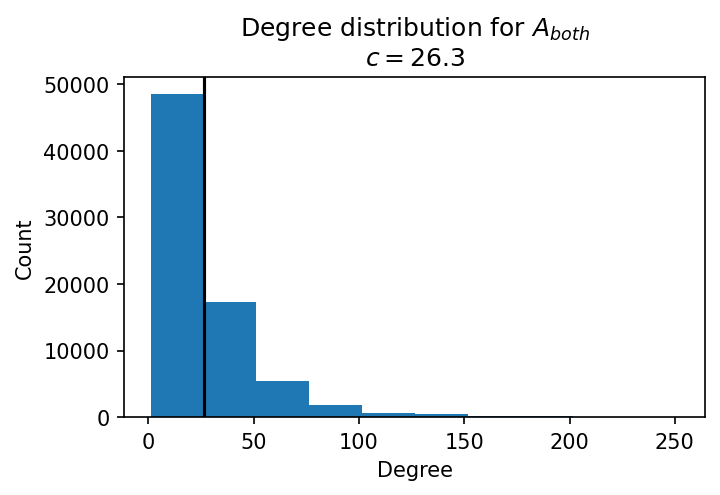

In [106]:
deg = Aboth.sum(axis=1)

fig, ax = plt.subplots(figsize=(5,3), dpi=150)
ax.hist(deg)
ax.set_ylabel("Count")
ax.set_xlabel("Degree")
ax.axvline(x=deg.mean(), ymin=0, ymax=1, color='black')
ax.set_title("Degree distribution for $A_{both}$" + "\n$c={0:.1f}$".format(deg.mean()))
plt.show()

# Save sparse matrices to disk

In [ ]:
with open('A_mat.pkl', 'wb') as f:
    pickle.dump(Aboth, f)